In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")
plt.rcParams['figure.dpi'] = 150
from toy_mc import generator
from importlib import reload

In [2]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = generator.OscPars(delta_msq_31, sinsq_2theta_23)

default_response = generator.Response(1., 0.08)
continuous_response = generator.ContinuousResponse(1., 0.08, 0.1)

bin_edges = np.logspace(1., 2., 26)

In [3]:
reload(generator)

gen = generator.Generator(int(1e4), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)
h0_true = gen.get_histogram(bin_edges, variable="true_energy")

cont_gen = generator.ContinuousResponseGenerator(int(1e4), continuous_response, default_pars)
h1 = cont_gen.get_histogram(bin_edges)

cont_gen.reweight_detector_response(default_response)
h1_weighted_to_default = cont_gen.get_histogram(bin_edges)

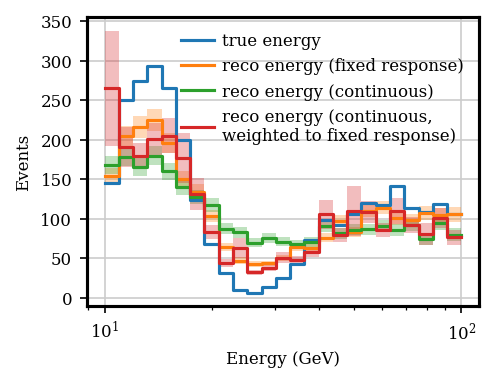

In [4]:
from toy_mc.histogram import plot_histogram

fig, ax = plt.subplots()
plot_histogram(h0_true, ax=ax, show_errorband=False, label="true energy")
plot_histogram(h0, ax=ax, label="reco energy (fixed response)")
plot_histogram(h1, ax=ax, label="reco energy (continuous)")
plot_histogram(h1_weighted_to_default, ax=ax, label="reco energy (continuous,\nweighted to fixed response)")
ax.set_xscale("log")
ax.set_xlabel("Energy (GeV)")
ax.set_ylabel("Events")
ax.legend()

# plt.savefig("plot_output/continuous_mc_analytic_response.pdf")

In [5]:
df = cont_gen.events
df

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,mu,sigma
0,6.933009,-1.0,0.837626,6.031661,0.677461,0.878505,0.08
1,29.704438,-1.0,0.056466,28.698357,0.057013,0.974784,0.08
2,19.088281,-1.0,0.293668,15.204626,0.192351,0.899764,0.08
3,5.135334,-1.0,0.020880,3.420309,0.000412,0.858682,0.08
4,14.202768,-1.0,0.925552,14.358835,0.925019,1.007216,0.08
...,...,...,...,...,...,...,...
9995,53.866184,-1.0,0.538483,46.225736,0.853533,1.047468,0.08
9996,33.507681,-1.0,0.137187,55.994249,0.069336,1.033768,0.08
9997,132.083765,-1.0,0.909746,114.222166,0.889785,0.945729,0.08
9998,21.787209,-1.0,0.100235,19.017179,0.091360,0.983452,0.08


In [6]:
from sklearn import preprocessing
from sklearn.compose import make_column_transformer

variables = ["reco_energy", "true_energy"]
data_encoder = make_column_transformer(
    (
        preprocessing.PowerTransformer(method="box-cox", standardize=True),
        variables,
    ),
    remainder="drop",
)
systematics = ["mu"]
position_encoder = make_column_transformer(
    (
        preprocessing.PowerTransformer(method="box-cox", standardize=True),
        systematics,
    ),
    remainder="drop",
)

X = data_encoder.fit_transform(df)
Y = position_encoder.fit_transform(df)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X, np.ones(len(X)))

KNeighborsClassifier(n_neighbors=10)

In [8]:
knn.kneighbors(X[:2], n_neighbors=10)

(array([[0.        , 0.00631628, 0.00684327, 0.01324267, 0.014416  ,
         0.01618226, 0.01949832, 0.02066912, 0.02245369, 0.0231123 ],
        [0.        , 0.00657115, 0.00850597, 0.01327071, 0.01692708,
         0.01784638, 0.01933483, 0.01937206, 0.02212514, 0.02239031]]),
 array([[   0, 9131, 6929, 5047, 7887, 6817, 6486, 6108, 6920,  229],
        [   1, 9538, 3951, 7491, 3545, 8614, 5906, 3820, 1574,  295]]))

In [28]:
from tqdm import tqdm
from numba import njit, prange
from scipy.optimize import minimize, check_grad

from surfaces import calculate_grads

reload(calculate_grads)


def fit_gradients(df, variables, gradient_names, n_neighbors=10, max_queries=None):
    """Return gradients for all events in a dataframe.

    The function first finds the nearest neighbrs of each query point in the training
    sample. It then calculates the differences of the query point to every other 
    point in the sample in the parameters named by grad_names, which may contain
    second order polynomials of the original parameters. The resulting gradients
    are then fit to the differences in the systematics named by grad_names.

    The resulting gradients have the shape (n_queries, n_systematics).

    Parameters
    ----------
    df : pandas.DataFrame
        Training sample.
    variables : list of str
        Names of the variables to be used for the neighborhood search. These must
        be columns in the dataframe.
    gradient_names : list of str
        Names of the gradients to be calculated. These must have the form 
        "grad__<systematic_name>". The systematic name must be a column in the
        dataframe.
    Returns
    -------
    grads : ndarray of shape (n_queries, n_systematics)
    """
    n_queries = len(df) if max_queries is None else max_queries
    n_features = len(variables)
    n_systematics = len(gradient_names)
    n_samples = len(df)

    output_grads = np.zeros((n_queries, n_systematics))

    data_encoder = make_column_transformer(
        (
            preprocessing.PowerTransformer(method="box-cox", standardize=True),
            variables,
        ),
        remainder="drop",
    )
    X = data_encoder.fit_transform(df)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, np.ones(n_samples))
    for i_query in tqdm(range(n_queries)):
        these_grads = np.zeros(n_features, dtype=np.float64)
        neigh_inds = knn.kneighbors(X[i_query].reshape(1, -1), n_neighbors=n_neighbors)[1][0]
        neighbor_indicator = np.zeros(n_samples)

        neighbor_indicator[neigh_inds] = 1

        w = np.ones((n_systematics, n_samples))
        for i, gradient_name in enumerate(gradient_names):
            for param in gradient_name.split("grad")[-1].split("__")[1:]:
                # The appropriate entry for the intercept term is always just a one.
                if param == "intercept":
                    continue
                w[i] *= df[param].values - df[param].values[i_query]
        # Starting guess is that gradients are zero.
        x0 = np.zeros(n_systematics)
        # bounds = [(-5, 5) for _ in range(n_systematics)]
        # Minimize!
        res = minimize(
            calculate_grads.nllh,
            x0,
            args=(w, neighbor_indicator),
            # bounds=bounds,
            # The gradient calculation for very large problem sizes is very slow.
            # We seem to be much slower than just using the numerical gradient.
            # jac=calculate_grads.nllh_grad,
            method="SLSQP",
            # options={"disp": False},
        )
        these_grads = res.x
        output_grads[i_query] = these_grads

    return output_grads

In [38]:
grad_names = ["grad__mu", "grad__mu__mu"]
variables = ["reco_energy", "true_energy"]

# Fit gradients
neigh_grads = fit_gradients(df, variables, grad_names, n_neighbors=100, max_queries=None)
neigh_grads

100%|██████████| 10000/10000 [02:09<00:00, 77.01it/s]


array([[   8.88898571,  -73.99456383],
       [   0.44458515, -104.97613771],
       [   2.74230851,  -75.03590505],
       ...,
       [   3.79406791,  -67.16355339],
       [  -4.92196539,  -78.25844995],
       [  -5.41263576,  -55.47188251]])

In [42]:
# store gradients to dataframe
for i, grad_name in enumerate(grad_names):
    df[grad_name] = neigh_grads[:, i]

In [43]:
df

,true_energy,true_cos(zen),weights_pre_detector,reco_energy,weights,mu,sigma,grad__mu,grad__mu__mu
0,6.933009,-1.0,0.837626,6.031661,0.677461,0.878505,0.08,8.888986,-73.994564
1,29.704438,-1.0,0.056466,28.698357,0.057013,0.974784,0.08,0.444585,-104.976138
2,19.088281,-1.0,0.293668,15.204626,0.192351,0.899764,0.08,2.742309,-75.035905
3,5.135334,-1.0,0.020880,3.420309,0.000412,0.858682,0.08,-7.458458,-40.341814
4,14.202768,-1.0,0.925552,14.358835,0.925019,1.007216,0.08,1.498361,-60.536859
...,...,...,...,...,...,...,...,...,...
9995,53.866184,-1.0,0.538483,46.225736,0.853533,1.047468,0.08,-11.831649,-63.423001
9996,33.507681,-1.0,0.137187,55.994249,0.069336,1.033768,0.08,18.180409,-98.432195
9997,132.083765,-1.0,0.909746,114.222166,0.889785,0.945729,0.08,3.794068,-67.163553
9998,21.787209,-1.0,0.100235,19.017179,0.091360,0.983452,0.08,-4.921965,-78.258450


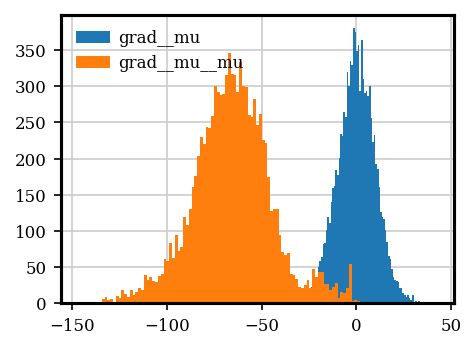

In [44]:
# make histograms of gradients
for grad_name in grad_names:
    plt.hist(df[grad_name], bins=100, label=grad_name)
plt.legend()


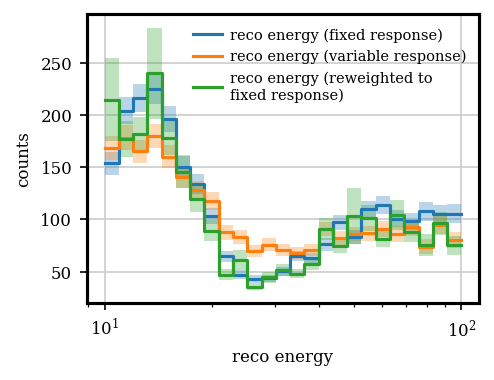

In [60]:
# Now we calculate weights that re-weight the sample to a particular response using the gradients
target_response = default_response
log_weights = np.zeros(len(df))
for grad_name in grad_names:
    delta = np.ones(len(df))
    for param in grad_name.split("grad")[-1].split("__")[1:]:
        # The appropriate entry for the intercept term is always just a one.
        if param == "intercept":
            continue
        delta *=  getattr(target_response, param) - df[param].values
    log_weights += df[grad_name].values * delta

weights = np.exp(log_weights)

from toy_mc import histogram
reweighted_hist = histogram.Histogram(bin_edges)
reweighted_hist.fill(df["reco_energy"].values, df["weights_pre_detector"].values * weights)

# Now we plot the reweighted histogram together with the original histogram
fig, ax = plt.subplots()
plot_histogram(h0, ax=ax, label="reco energy (fixed response)")
plot_histogram(h1, ax=ax, label="reco energy (variable response)")
plot_histogram(reweighted_hist, ax=ax, label="reco energy (reweighted to\nfixed response)")
ax.legend(fontsize=7)
ax.set_xlabel("reco energy")
ax.set_ylabel("counts")

# ax.set_ylim((0, 1000))
ax.set_xscale("log")
plt.savefig("plot_output/continuous_ultrasurface_reweighting.pdf")
